# Collagen Segmentation Workflow on Large WSI

This notebook will demonstrate a highly parallelized pipeline for large whole slide imaging (WSI) collagen segmentation. This includes:

1. Effective data IO on tiled regions for 2D CZI data from Axioscan 7.
2. Perform color deconvolution with user given stain vectors to separate Picrosirius Red (PSR) and Fast-Green (FG) stained histology images.
3. An automated detection method for collagen segmentation
4. A parallel processing scheme for accelerated data processing
5. Exporting of data to OME Tiff format for further analysis.

In [ ]:
from bioio_ome_tiff import OmeTiffWriter
from bioio import BioImage
from bioio.types import PhysicalPixelSizes
import aicspylibczi
import pathlib
import histomicstk as htk

from tqdm import tqdm
import numpy as np
from skimage.transform import resize
from skimage.filters import threshold_multiotsu
from skimage import exposure
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

import multiprocessing
from multiprocessing import Pool
from threading import Lock

import os

## Data Loading

In [2]:
# INPUT_DATA = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00655-A7-025-M-Adv-PSR.czi"
# OUTPUT_DIR = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00655-A7-025-M-Adv-PSR"

INPUT_DATA = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00561-A4-002-M-less-PSR.czi"
OUTPUT_DIR = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00561-A4-002-M-less-PSR"

For large slide scanning we need to load headers from two packages

In [ ]:
image = aicspylibczi.CziFile(pathlib.Path(INPUT_DATA))
image_ = BioImage(INPUT_DATA, reconstruct_mosaic=False)

In [4]:
image_np = np.zeros((image.get_mosaic_bounding_box().w, image.get_mosaic_bounding_box().h,3), dtype=np.uint16)
print("image size (px):",image_np.shape)
tle_bboxes = image.get_all_mosaic_tile_bounding_boxes()

x_ = [bbox.x for bbox in tle_bboxes.values()]
y_ = [bbox.y for bbox in tle_bboxes.values()]

image size (px): (157528, 104741, 3)


In [7]:
def read_tile(args):
    path, m, bbox, x_offset, y_offset = args
    image = aicspylibczi.CziFile(pathlib.Path(path))

    tile = image.read_mosaic((
        image.get_mosaic_tile_bounding_box(M=m).x, 
        image.get_mosaic_tile_bounding_box(M=m).y, 
        image.get_mosaic_tile_bounding_box(M=m).w, 
        image.get_mosaic_tile_bounding_box(M=m).h
    ), C=0)

    x_start =  bbox["x"]-x_offset
    x_end = x_start+bbox["w"]
    y_start = bbox["y"]-y_offset
    y_end = y_start+bbox["h"]
    image_tile = np.transpose(tile[0,:,:,:],(1,0,2)).astype(np.uint16)

    return {
        "x_start":x_start,
        "x_end":x_end,
        "y_start":y_start,
        "y_end":y_end,
        "image_tile":image_tile
        }

In [8]:
# prepare process regions
data_to_process = []
for m, bbox in tqdm(enumerate(tle_bboxes.values()),desc="Preparing tile bounds",total=len(tle_bboxes)):
    data_to_process.append((INPUT_DATA, m, {"x":bbox.x, "y":bbox.y, "w":bbox.w, "h":bbox.h}, np.min(x_), np.min(y_)))

with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    results = list(tqdm(pool.imap(read_tile, data_to_process[:]), total=len(tle_bboxes), desc="Reading tiles"))

for res in tqdm(results,desc="Merging"):
    image_np[res["x_start"]:res["x_end"],res["y_start"]:res["y_end"],:] = res["image_tile"]
    del res

Reading tiles:   0%|          | 0/2715 [00:00<?, ?it/s]


PylibCZI_CDimCoordinatesUnderspecifiedException: The coordinates are underspecified = you have not specified a Dimension that is required. More than 1 tile matched. Be more specific.

(-0.5, 1158.5, 1263.5, -0.5)

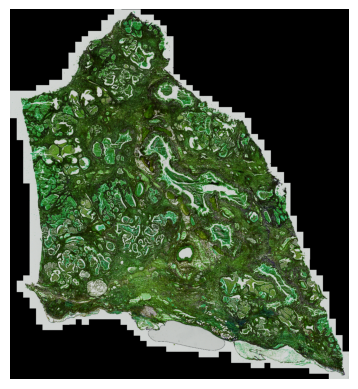

In [7]:
# plot subsampled image
image_np_subsampled = image_np[::100,::100,:]
plt.imshow(image_np_subsampled)
plt.axis("off")

## Color Deconvolution

In [8]:
def tiled_deconv_helper(image,roi,W):
    imDeconvolved_batch = htk.preprocessing.color_deconvolution.color_deconvolution(image, W)
    return {"image_tile": imDeconvolved_batch.Stains, "roi":roi}

In [9]:
def stain_vector_separation_large(image, stain_color_map, stains, tile_size=2048, threads=0, batch_size=32):
    print('stain_color_map:', stain_color_map, sep='\n')

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = np.zeros_like(image)

    n_rows, n_cols = image.shape[0:2]

    if threads < 2:
        n_row_batches = (n_rows+batch_size-1)//tile_size
        n_col_batches = (n_cols+batch_size-1)//tile_size

        # create progress bar:
        pbar = tqdm(total=n_row_batches*n_col_batches, desc="Tile deconvolving")

        # this section can be parallelized
        for row_start in range(0,n_rows, tile_size):
            for col_start in range(0,n_cols, tile_size):
                row_end = min(row_start+tile_size, n_rows)
                col_end = min(col_start+tile_size, n_cols)

                # extract a batch from the image tile
                batch = image[row_start:row_end, col_start:col_end, :]

                # tile deconvolution
                imDeconvolved_batch = htk.preprocessing.color_deconvolution.color_deconvolution(batch, W)
                
                # update the output image
                imDeconvolved[row_start:row_end, col_start:col_end] = imDeconvolved_batch.Stains

                pbar.update(1)
        
        pbar.close()
    else:
        region_to_process = []
        for row_start in range(0,n_rows, tile_size):
            for col_start in range(0,n_cols, tile_size):
                row_end = min(row_start+tile_size, n_rows)
                col_end = min(col_start+tile_size, n_cols)
                region_to_process.append((row_start,row_end,col_start,col_end))

        tqdm.write("{} tiles to process".format(len(region_to_process)))

        # run the tiled parallel processing in batch
        if len(region_to_process) % batch_size == 0:
            batch_count = len(region_to_process) // batch_size
        else:
            batch_count = len(region_to_process) // batch_size + 1

        for batch_id in tqdm(range(batch_count), desc="Batch progress"):
            region_to_process_chuck = []

            # batch size for tqdm update only
            if len(region_to_process) < batch_size*(batch_id+1):
                batch_size_ = len(region_to_process)%batch_size
            else:
                batch_size_ = batch_size

            for i in tqdm(range(batch_size_),desc="Loading tiles in batch {}".format(batch_id)):
                tile_idx = batch_id*batch_size + i
                if tile_idx < len(region_to_process):
                    row_start, row_end, col_start, col_end = region_to_process[tile_idx]
                    if isinstance(image, np.ndarray):
                        region_to_process_chuck.append({"tile": image[row_start:row_end,col_start:col_end,:],"roi":(row_start,row_end,col_start,col_end)})
                    else:
                        region_to_process_chuck.append({"tile": image[row_start:row_end,col_start:col_end,:].compute(),"roi":(row_start,row_end,col_start,col_end)})
                else:
                    break

            pbar = tqdm(desc="Tiled color deconvolution in parallel in batch {}/{}".format(batch_id, batch_count),total=batch_size_)
            pbar.clear()

            mutex = Lock()

            def callback_fn(res):
                pbar.update(1)
                row_start,row_end,col_start,col_end = res["roi"]
                img_tile = res["image_tile"]
                with mutex:
                    # imDeconvolved[row_start:row_end,col_start:col_end,:] = da.from_array(img_tile)
                    imDeconvolved[row_start:row_end,col_start:col_end,:] = np.copy(img_tile)

            def callback_err(err):
                print(err)

            # Create a Pool with the specified number of processes
            pool = Pool(threads) # control number of threads to limit memory consumption
            for region in region_to_process_chuck:
                tile = region["tile"]
                roi = region["roi"]
                pool.apply_async(tiled_deconv_helper, (tile,roi,W), callback=callback_fn, error_callback=callback_err)
            pool.close()
            pool.join()
            pbar.close()

    return imDeconvolved

In [10]:
# human
stain_color_map = {
    'PSR': [0.376,0.787,0.489],
    'FG': [0.943,0.217,0.254],
    'Residual': [0.123,0.480,-0.868]
}

background = [207,209,206]

In [11]:
# get an intermediate subsampling here for quick debug
imDeconvolved = stain_vector_separation_large(image_np[::10,::10,:], stain_color_map, stains=stain_color_map.keys(), tile_size=4096,threads=multiprocessing.cpu_count(), batch_size=16)

stain_color_map:
{'PSR': [0.376, 0.787, 0.489], 'FG': [0.943, 0.217, 0.254], 'Residual': [0.123, 0.48, -0.868]}
12 tiles to process


Loading tiles in batch 0: 100%|██████████| 12/12 [00:00<00:00, 276547.52it/s]

                                                                                       

Tiled color deconvolution in parallel in batch 0/1: 100%|██████████| 12/12 [00:20<00:00,  1.75s/it]
Batch progress: 100%|██████████| 1/1 [00:20<00:00, 20.97s/it]


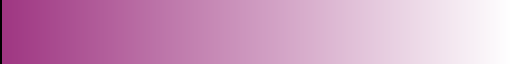

In [12]:
psr_cmap = LinearSegmentedColormap.from_list("PSR", [(0,"black"),(1/255, 1- np.asarray(stain_color_map["PSR"])), (1,'white')],gamma=1.0)
psr_cmap

(-0.5, 1158.5, 1263.5, -0.5)

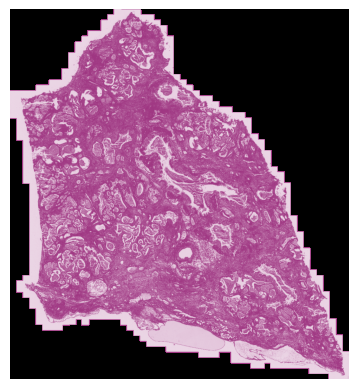

In [13]:
# plot subsampled image
imDeconvolved_subsampled = imDeconvolved[::10,::10,:]
plt.imshow(imDeconvolved_subsampled[:,:,0],cmap=psr_cmap)
plt.axis("off")

## Collagen Segmentation

In [14]:
# Tissue Mask
psr_image = imDeconvolved[:,:,0]
# Down sample for quick computation
if not isinstance(psr_image,np.ndarray):
    psr_image_subsampled = psr_image[::10,::10].compute()
else:
    psr_image_subsampled = psr_image[::10,::10]

# otsu thresholding
thresholds = threshold_multiotsu(psr_image_subsampled,classes=3)

# Using the threshold values, we generate the three regions.
regions = np.digitize(psr_image_subsampled, bins=thresholds)

tissue_mask_subsampled = regions
tissue_mask_subsampled[tissue_mask_subsampled!=1] = 0

filled_tissue_mask_subsampled = tissue_mask_subsampled
filled_tissue_mask_subsampled = ndimage.binary_closing(filled_tissue_mask_subsampled, structure=np.ones((25,25))).astype(int)
filled_tissue_mask_subsampled = ndimage.binary_fill_holes(filled_tissue_mask_subsampled, structure=np.ones((5,5))).astype(int)

In [15]:
# rescale mask back to original dim
tissue_mask = resize(tissue_mask_subsampled.astype(bool), psr_image.shape,anti_aliasing=False)
filled_tissue_mask = resize(filled_tissue_mask_subsampled.astype(bool), psr_image.shape,anti_aliasing=False)

# mask the original data
psr_image_filtered = np.copy(psr_image)
psr_image_filtered[filled_tissue_mask==0] = 0

(-0.5, 1158.5, 1263.5, -0.5)

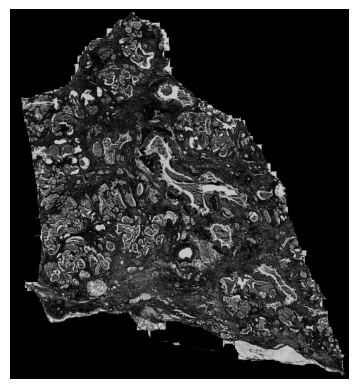

In [16]:
# plot subsampled masked PSR image
plt.imshow(psr_image_filtered[::10,::10],cmap="gray")
plt.axis("off")

In [17]:
print("Calculating multiple Otsu values...")
thresholds = threshold_multiotsu(psr_image_filtered[::1,::1],classes=4) # full size requires high memory usage, consistency not tested
# thresholds = threshold_multiotsu(psr_image_filtered,classes=3)
threshold = thresholds[0]
print("Otsu threshold value: ", threshold)

Calculating multiple Otsu values...
Otsu threshold value:  23


In [18]:
# Segmentation
collagen = np.zeros_like(psr_image_filtered,dtype=np.uint8)
collagen[(psr_image_filtered>0) & (psr_image_filtered<threshold)] = 1

In [19]:
psr_image_filtered_ = np.stack([psr_image_filtered]*3,axis=-1)
psr_image_filtered_[collagen==1] = [255,0,0]

In [20]:
SUBREGION=[psr_image.shape[0]//2-1024//2,psr_image.shape[1]//2-1024//2,1024,1024]

In [21]:
psr_image_crop = psr_image[SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]
psr_image_crop_ = np.stack([psr_image_crop]*3,axis=-1)
psr_image_crop_[collagen[SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]==1] = [255,0,0]

(-0.5, 1023.5, 1023.5, -0.5)

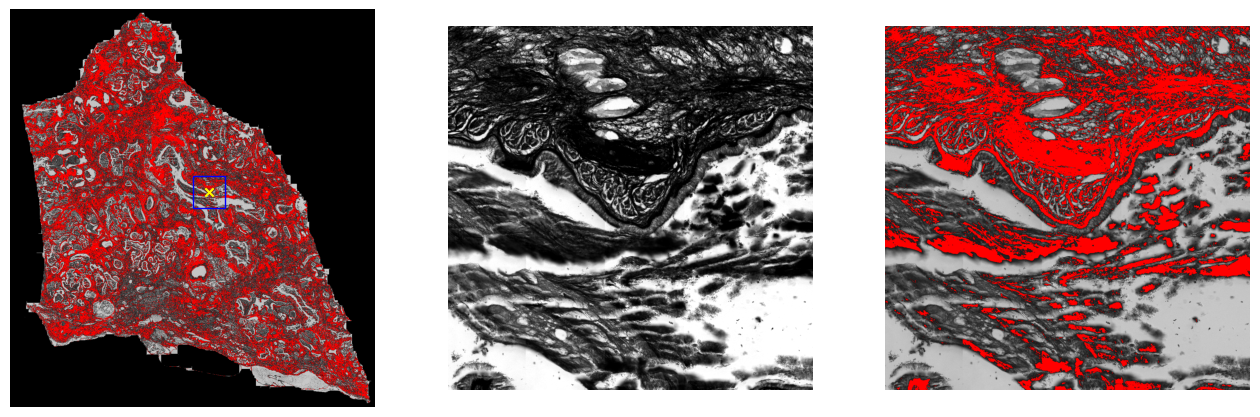

In [22]:
# plot masked PSR image
fig, axs = plt.subplots(1,3,figsize=(16,8))

axs[0].imshow(psr_image_filtered_[::10,::10])
axs[0].axis("off")
rect = patches.Rectangle((SUBREGION[0]/10,SUBREGION[1]/10), SUBREGION[2]/10, SUBREGION[3]/10, linewidth=1, edgecolor='b', facecolor='none')
# Add the patch to the Axes
axs[0].add_patch(rect)
axs[0].scatter(psr_image.shape[0]//2/10,psr_image.shape[1]//2/10,marker="x",c="yellow")

axs[1].imshow(exposure.rescale_intensity(psr_image_crop, in_range=(np.percentile(psr_image_crop,5),np.percentile(psr_image_crop,95))),cmap="gray",)
axs[1].axis("off")

axs[2].imshow(psr_image_crop_)
axs[2].axis("off")

In [23]:
# Area Quantification
pixel_size = image_.physical_pixel_sizes.X*image_.physical_pixel_sizes.Y

collagen_area = np.sum(collagen)*pixel_size
tissue_area = np.sum(tissue_mask)*pixel_size
filled_tissue_area = np.sum(filled_tissue_mask)*pixel_size

res = {
    "collagen (um^2)": collagen_area,
    "tissue (um^2)": tissue_area,
    "filled_tissue (um^2)": filled_tissue_area,
    "collagen vs tissue (%)": collagen_area/tissue_area*100,
    "collagen vs filled tissue (%)": collagen_area/filled_tissue_area*100,
    }
res

{'collagen (um^2)': 755507.6465062499,
 'tissue (um^2)': 707792.0713312499,
 'filled_tissue (um^2)': 2339244.3876749994,
 'collagen vs tissue (%)': 106.74146788409966,
 'collagen vs filled tissue (%)': 32.29708065078045}

## Data Export

In [ ]:
# pps = PhysicalPixelSizes(X=image_.physical_pixel_sizes.X*10, Y=image_.physical_pixel_sizes.Y*10, Z=None)
pps = PhysicalPixelSizes(X=1.725, Y=1.725, Z=None)
pps

In [ ]:
os.makedirs(OUTPUT_DIR,exist_ok=True)

#  save PSR channel
OmeTiffWriter.save(psr_image_filtered.astype(np.uint8).T,os.path.join(OUTPUT_DIR,"PSR.ome.tiff"),
        physical_pixel_sizes=pps,
        dim_order="YX",
)

#  save mask
collagen_ = collagen*255
OmeTiffWriter.save(collagen_.astype(np.uint8).T,os.path.join(OUTPUT_DIR,"collagen.ome.tiff"),
        physical_pixel_sizes=pps,
        dim_order="YX",
)